In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
#import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, XGBRegressor

In [4]:
df=pd.read_csv('d_final_mehico.csv')
# df.head()
len(df)

121395

In [5]:
# 생존자 제거
freq = df['DEATH'].value_counts()
print(freq)
survive = df[df['DEATH']==0].index
df1 = df.drop(survive)

0    88993
1    32402
Name: DEATH, dtype: int64


In [6]:
# featrues; x
features= df1.loc[:, ['sex', 'intubed','pneumonia','age_grp','pregnancy', 'diabetes', 
                 'copd', 'asthma','inmsupr','hypertension','other_disease',
                 'cardiovascular','obesity', 'renal_chronic', 'tobacco', 
                 'contact_other_covid', 'covid_res', 'icu']]

# label; y 
label = df1.loc[:, ['diff_days']] # regression

In [7]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
feature_n = MinMaxScaler(feature_range=(0,1)).fit_transform(features)
feature_n

array([[0. , 0.5, 1. , ..., 1. , 0. , 0.5],
       [1. , 0.5, 0. , ..., 1. , 0. , 0. ],
       [1. , 0.5, 0. , ..., 1. , 0. , 0.5],
       ...,
       [1. , 0.5, 1. , ..., 1. , 1. , 0.5],
       [0. , 0. , 0. , ..., 0. , 1. , 0.5],
       [1. , 0. , 0. , ..., 0.5, 1. , 0. ]])

In [14]:
# Train, Test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1004)

In [15]:
print(X_train.shape[:], y_train.shape[:], X_test.shape[:], y_test.shape[:])

(25921, 18) (25921, 1) (6481, 18) (6481, 1)



Emsemble model - XGBoost

    모델 사용 이유 : kaggle 등에서 성능이 좋아서 최근 많이 쓰임
    Gradient Boosting model 보다 계산 속도 빠름
    참고 : https://lsjsj92.tistory.com/547

    병렬 처리를 사용하기에 학습과 분류가 빠르다
    유연성이 좋다. 커스텀 최적화 옵션을 제공한다
    욕심쟁이(Greedy-algorithm)을 사용한 자동 가지치기가 가능하다. 과적합이 잘일어나지 않는다.
    다른 알고리즘과 연계하여 앙상블 학습이 가능하다.

XGBoost Hyper Parameter Tuning

    Regression model에서는 Tuning에 시간이 너무 오래걸려서 GridSearchCV 하지 않음
    그냥 Classification model에서의 최적 파라미터로 train



In [16]:
# Model Building

xgb = XGBRegressor()

xgb_params_grid = {
    'n_estimators' : [100, 200, 300, 400, 500], # 결정 트리 개수
    'learning_rate' : [0.001, 0.01, 0.05, 0.10, 0.15, 0.2], # 학습률
    'max_depth' : [4, 6, 8, 10 ,12], # 트리 깊이
    'random_state' : [1004], # seed 설정
    'objective' : ['reg:linear']
}

xgb_model = GridSearchCV(xgb, param_grid = xgb_params_grid, 
                        scoring = "neg_root_mean_squared_error", 
                        cv = KFold(5, random_state = 1004), # 5-fold CV 수행
                        n_jobs = 4, # 병렬 처리 개수 : -1은 전부
                        verbose = 1)

In [17]:
# Model Learning
Y_train2 = y_train.loc[:, "diff_days"]
xgb_model.fit(X_train, Y_train2)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 13.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 32.0min
[Parallel(n_jobs=4)]: Done 750 out of 750 | elapsed: 54.5min finished


[06:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=1004, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mo...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=4,
             param_grid={'le

In [18]:
# 최적 parameter 확인
print("Best parameters (5-fold CV, gird search): " , xgb_model.best_params_)
print("Best accuracy (5-fold CV, gird search): " , xgb_model.best_score_)

Best parameters (5-fold CV, gird search):  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'objective': 'reg:linear', 'random_state': 1004}
Best accuracy (5-fold CV, gird search):  -7.393033250452705


In [24]:
cv_result_df = pd.DataFrame(xgb_model.cv_results_)
cv_result_df.sort_values(by=['rank_test_score'], inplace=True)

In [25]:
cv_result_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
29,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-7.393033,1
50,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",-7.393928,2
28,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-7.395526,3
51,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",-7.400202,4
75,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-7.401362,5


In [26]:
# 최적 parameter로 xgboost 모델 생성 및 예측
xgb_best = xgb_model.best_estimator_
Y_pred = xgb_best.predict(X_test) ; Y_pred # 예측값

array([ 8.274761, 10.764055, 10.717618, ..., 10.910509, 10.138329,
       11.749681], dtype=float32)

In [27]:
xgb_best

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=1004, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [28]:
# Test set 성능평가
Y_test2 = y_test.loc[:, "diff_days"] # True 값
Y_test2 = Y_test2.reset_index(drop=True)
print('RMSE : %.3f' % np.sqrt(mean_squared_error(Y_test2, Y_pred)))

RMSE : 7.179


In [29]:
# X축 : Y, Y축 : predicted Y 산점도 작성

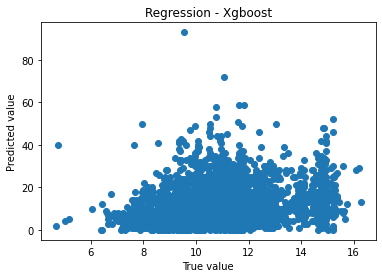

In [30]:
plt.plot(Y_pred, Y_test2, 'o')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Regression - Xgboost')
plt.show()

In [31]:
# Y, Predicted Y export (나중에 그래프 그릴 때 쓰게)

In [32]:
d_trueY = pd.DataFrame({'Y_pred':Y_test2}).reset_index(drop=True)
d_predY = pd.DataFrame({'Y_pred':Y_pred})

In [33]:
reg_xgboost = pd.concat([d_trueY, d_predY], axis = 1).reset_index(drop=True)
reg_xgboost

,Y_pred,Y_pred
0,8,8.274761
1,14,10.764055
2,7,10.717618
3,15,8.635523
4,16,11.228484
...,...,...
6476,11,11.424531
6477,17,10.166816
6478,16,10.910509
6479,15,10.138329


In [34]:
reg_xgboost.to_csv('reg_xgboost.csv', encoding='utf-8', index=False, line_terminator='\n')

In [ ]:
# RMSE : 7.179